In [1]:

import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import os
import matplotlib

from torch import nn
from helpers import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from os.path import exists
from argparse import ArgumentParser

matplotlib.use('Agg')

In [2]:

parser = ArgumentParser()

parser.add_argument("-c", "--cuda", dest="cuda", default=0, type=int, help='Cuda number')
parser.add_argument("--nn-hidden", dest="nn_hidden", default=3, type=int, help='Number of hidden layers for the NN')
parser.add_argument("--nn-nodes", dest="nn_nodes", default=200, type=int, help='Number of hidden nodes for NN')
parser.add_argument("--lr", dest="lr", default=0.01, type=float, help='Learning rate (to start with)')
parser.add_argument("--batch", dest="batch", default=500, type=int, help='Batch Size')
parser.add_argument("--output", dest="output", default='nn_dummy/', type=str, help='Path for output files')
parser.add_argument("--test", dest="test", default=0, type=int, help='Test run {True, False}')
args = parser.parse_args()
# pass default arguments if executed as ipynb
try: 
    if get_ipython().__class__.__name__ == 'ZMQInteractiveShell': args = parser.parse_args("") 
except:
    args = parser.parse_args()

Namespace(batch=500, cuda=0, lr=0.01, nn_hidden=3, nn_nodes=200, output='nn_dummy/', test=0)


In [3]:
ensure_dir(args.output)
device = args.cuda

In [4]:
#
# Load data
#

In [5]:
if exists('/ceph/lsowa/recoil/dt.root'):
    # when on local machine
    dfdata = load_from_root('/ceph/lsowa/recoil/dt.root', test=args.test)
    dfmc = load_from_root('/ceph/lsowa/recoil/mc.root', test=args.test)
else:
    # when running on cluster
    dfdata = load_from_root('recoil/dt.root', test=args.test)
    dfmc = load_from_root('recoil/mc.root', test=args.test)

Reading files from:  /ceph/lsowa/recoil/dt.root
No.  1
No.  2
No.  3
No.  4
No.  5
Reading files from:  /ceph/lsowa/recoil/mc.root
No.  1
No.  2
No.  3
No.  4
No.  5
No.  6
No.  7


In [6]:
cond = ['metphi','pt_vis_c', 'phi_vis_c','pt_1', 'pt_2','dxy_1', 'dxy_2','dz_1',
        'dz_2','eta_1', 'eta_2','mass_1', 'mass_2','metSumEt']
names = ['uP1_uncorrected', 'uP2_uncorrected']

In [7]:
data = dfdata[names].to_numpy().astype(float)
mc = dfmc[names].to_numpy().astype(float)
cdata = dfdata[cond].to_numpy().astype(float)
cmc = dfmc[cond].to_numpy().astype(float)

In [ ]:
del dfdata, dfmc

In [8]:
#
# Preprocess data
#

In [9]:
# Z standardize inputs
input_scaler = StandardScaler()
data = input_scaler.fit_transform(data)
mc = input_scaler.transform(mc)

cond_scaler = StandardScaler()
cdata = cond_scaler.fit_transform(cdata)
cmc = cond_scaler.transform(cmc)

In [10]:
# train test split
data, data_val, cdata, cdata_val = train_test_split(data, cdata, test_size=0.2)

data, mc, cdata, cmc = torch.tensor(data), torch.tensor(mc), torch.tensor(cdata), torch.tensor(cmc)
data_val, cdata_val = torch.tensor(data_val).to(device), torch.tensor(cdata_val).to(device)

In [11]:
data, mc, cdata, cmc = torch.tensor(data), torch.tensor(mc), torch.tensor(cdata), torch.tensor(cmc)

/ceph/lsowa/envs/cluster/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [12]:
print('Train (Data): ', data.shape, ' Conditions: ', cdata.shape)
print('Val (Data): ', data_val.shape, ' Conditions: ', cdata_val.shape)
print('Test (MC): ', mc.shape, ' Conditions: ', cmc.shape)

Train (Data):  torch.Size([1436919, 2])  Conditions:  torch.Size([1436919, 14])
Val (Data):  torch.Size([359230, 2])  Conditions:  torch.Size([359230, 14])
Test (MC):  torch.Size([2189044, 2])  Conditions:  torch.Size([2189044, 14])


In [13]:
#
# Model Setup
#

In [14]:


model = Mlp(input_neurons=cdata.shape[1], hidden_neurons=args.nn_nodes, output_neurons=2, hiddenlayers=args.nn_hidden)

In [15]:
#
# model training
#

In [16]:
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, 
                                                    patience=3, verbose=True)
mse = nn.MSELoss()

In [17]:
#data, cdata = data[:100,:].to(device), cdata[:100,:].to(device)
dataset = TensorDataset(data, cdata)
loader = DataLoader(dataset, shuffle=True, batch_size=args.batch, num_workers=4, pin_memory=True)

In [18]:
pz = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
model.to(device)

losses = []
losses_val = []
nbatches = len(loader)
stopper=0
best_loss=np.inf
epoch = 0
loss_val = np.inf
best_model_dict = None

while stopper<=15:
    epo_loss = 0
    for d, c in loader:
        d = d.to(device)
        c = c.to(device)
        
        u = model(c.float())
        loss = mse(u.float(), d.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epo_loss += loss.cpu().detach().numpy()
    epo_loss /= nbatches
    epo_loss = round(epo_loss,5)
    scheduler.step(epo_loss)
    losses.append(epo_loss)
    
    # validation
    u = model(cdata_val.float())
    #z, log_jac = evaluate_sequential(model, data_val.float(), cond=cdata_val.float())
    loss_val = mse(u.float(), data_val.float())
    loss_val = loss_val.cpu().detach().numpy()
    losses_val.append(loss_val)
    if loss_val >= best_loss: 
        stopper+=1
    else:
        best_loss = loss_val
        stopper = 0
        best_model_dict = model.state_dict()
    epoch += 1
    print('Epoch: {:.0f}; train Loss: {:.3f}; val Loss: {:.3f}; stopper: {:.0f}; best val loss: {:.3f}\n'.format(epoch, epo_loss, loss_val, stopper, best_loss))
    
    if epoch >= args.test and args.test > 0:
        break

Epoch: 1; train Loss: 0.657; val Loss: 0.649; stopper: 0; best val loss: 0.649

Epoch: 2; train Loss: 0.644; val Loss: 0.643; stopper: 0; best val loss: 0.643

Epoch: 3; train Loss: 0.644; val Loss: 0.643; stopper: 0; best val loss: 0.643

Epoch: 4; train Loss: 0.644; val Loss: 0.644; stopper: 1; best val loss: 0.643

Epoch: 5; train Loss: 0.644; val Loss: 0.642; stopper: 0; best val loss: 0.642

Epoch: 6; train Loss: 0.643; val Loss: 0.641; stopper: 0; best val loss: 0.641

Epoch: 7; train Loss: 0.643; val Loss: 0.643; stopper: 1; best val loss: 0.641

Epoch: 8; train Loss: 0.643; val Loss: 0.643; stopper: 2; best val loss: 0.641

Epoch: 9; train Loss: 0.642; val Loss: 0.641; stopper: 0; best val loss: 0.641

Epoch: 10; train Loss: 0.643; val Loss: 0.643; stopper: 1; best val loss: 0.641

Epoch: 11; train Loss: 0.643; val Loss: 0.641; stopper: 0; best val loss: 0.641

Epoch: 12; train Loss: 0.642; val Loss: 0.641; stopper: 1; best val loss: 0.641

Epoch    13: reducing learning rate o

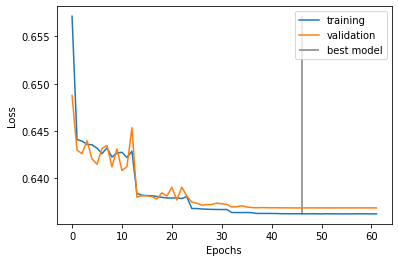

In [19]:
plt.plot(losses, label='training')
plt.plot(losses_val, label='validation')
plt.vlines(len(losses)-stopper, ymin=np.min(losses), ymax=np.max(losses), 
            label='best model', colors=['grey'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(args.output+'loss.pdf')
plt.clf()

In [20]:
model.load_state_dict(best_model_dict)

<All keys matched successfully>

In [21]:
torch.save(model.state_dict(), args.output+'model.pt')
#os.system('cp ' + os.path.basename(__file__) + ' ' + args.output + 'code.py') 